In [1]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 19 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=1fbd1b7e7e7ab1e741fbad3f69b519359451c733e1902ae5f7d22589f3efe006
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [2]:
from PIL import Image, ImageDraw
import face_recognition
import scipy.constants
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img, img_to_array

from PIL import Image as Img
from PIL import ImageTk

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### chụp ảnh trên colab

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/gdrive/MyDrive/khuonmat/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to /content/gdrive/MyDrive/khuonmat/photo.jpg


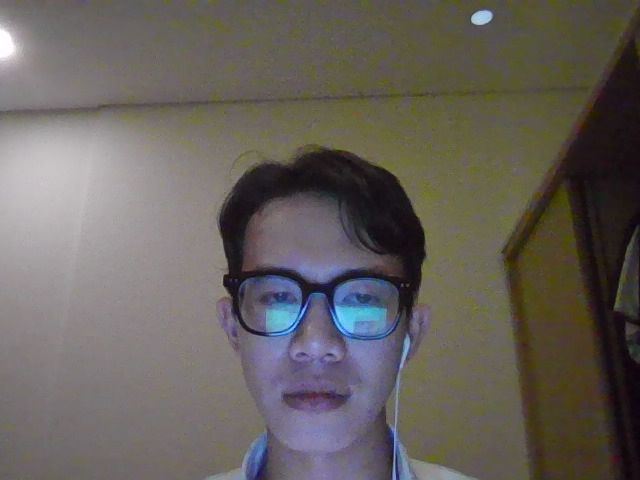

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Huấn luyện mô hình nhận dạng khuôn mặt

In [8]:
folder= '/content/gdrive/MyDrive/khuonmat/training/'

photos, labels = list(), list()
for file in listdir(folder):
  if file.startswith('phu'):
    output = 0
    name ='Nguyen Cong Phu'
    photo = load_img(folder+file,target_size=(150,150))
    photo = img_to_array(photo)
    photos.append(photo)
    labels.append(output)

photos = asarray(photos)
labels = asarray(labels)
print(photos.shape,labels.shape)

save('NhanDangKhuonMat_photos.npy', photos)
save('NhanDangKhuonMat_labels.npy', labels)

(3, 150, 150, 3) (3,)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten # BatchNormalization: để dùng GPU ko lỗi
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(photos, labels, epochs=100, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [10]:
model.save('NhanDangKhuonMat.h5')

In [11]:
from keras.models import load_model
models=load_model('NhanDangKhuonMat.h5')

Giá trị: 0
Nguyen Cong Phu
Xin mời thực hiện các bước tiếp theo để tính tỷ lệ vàng khuôn mặt


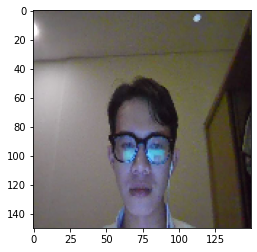

In [12]:
from keras.saving.model_config import model_from_json
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
img = load_img('/content/gdrive/MyDrive/khuonmat/photo.jpg', target_size=(150,150))
plt.imshow(img)
img = img_to_array(img)
img = img.reshape(1,150,150,3) 
img = img.astype('float32')
img = img/255
np.argmax(models.predict(img), axis=1)
print('Giá trị:', np.argmax(models.predict(img)))
if np.argmax(models.predict(img)) == 0:
   print(name)
   print("Xin mời thực hiện các bước tiếp theo để tính tỷ lệ vàng khuôn mặt")
else:
    print("Cảnh báo! Khuôn mặt không xác định, vui lòng cân nhắc trước khi thực hiện tiếp các bước.")

### Ảnh để tính tỷ lệ vàng khuôn mặt

In [13]:
path = '/content/gdrive/MyDrive/khuonmat/'  # Lưu ý: thêm "/" vào sau link
name = 'photo.jpg'
### link của ảnh
photo = f"{path}" + f"{name}"

In [14]:
cv2.imread(photo)

array([[[111, 108, 117],
        [110, 107, 116],
        [110, 107, 116],
        ...,
        [ 58,  74,  81],
        [ 60,  69,  79],
        [ 60,  66,  77]],

       [[112, 109, 118],
        [111, 108, 117],
        [111, 108, 117],
        ...,
        [ 57,  70,  78],
        [ 59,  65,  76],
        [ 59,  63,  74]],

       [[113, 110, 119],
        [112, 109, 118],
        [111, 108, 117],
        ...,
        [ 56,  67,  75],
        [ 59,  63,  74],
        [ 59,  61,  72]],

       ...,

       [[ 87,  93,  98],
        [ 88,  94,  99],
        [ 92,  95, 100],
        ...,
        [ 20,  14,  25],
        [ 19,  13,  24],
        [ 18,  12,  23]],

       [[ 89,  95, 100],
        [ 89,  95, 100],
        [ 92,  95, 100],
        ...,
        [ 20,  14,  25],
        [ 19,  13,  24],
        [ 18,  12,  23]],

       [[ 90,  96, 101],
        [ 90,  96, 101],
        [ 93,  96, 101],
        ...,
        [ 20,  14,  25],
        [ 19,  13,  24],
        [ 18,  12,  23]]

### Xác định landmark trong ảnh

In [15]:
image = face_recognition.load_image_file(photo)

face_landmarks_list = face_recognition.face_landmarks(image) 

if (len(face_landmarks_list))>1:
   print("Cảnh báo, có quá nhiều khuôn mặt trong ảnh!")
elif (len(face_landmarks_list))==0:
   print("Xin lỗi, chúng tôi không thấy mặt người trong ảnh!")

pil_image = Img.fromarray(image)
d = ImageDraw.Draw(pil_image)

In [16]:
nose_top=[]

#extraction of coordinates
lists=[]
   
for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        #print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))
        lists.append(face_landmarks[facial_feature])  #first list is chin, 2nd list is left eyebrow, 3rd is right eyebrow, 4th is nose bridge, 5th is nose tip, 6th is left eye, 7th is right eye, 8th is top lip, 9th is bottom lip
    n=0
    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        n=n+1
        m=str(n)
        d.point(face_landmarks[facial_feature])


In [17]:
# Show the picture
# pil_image.show()
pil_image.save('/content/gdrive/MyDrive/khuonmat/my_face_landmarks.jpg')

chin=[]
left_eyebrow=[]
right_eyebrow=[]
nose_bridge=[]
nose_tip=[]
left_eye=[]
right_eye=[]
top_lip=[]
bottom_lip=[]

chin.append(lists[0])
left_eyebrow.append(lists[1])
right_eyebrow.append(lists[2])
nose_bridge.append(lists[3])
nose_tip.append(lists[4])
left_eye.append(lists[5])
right_eye.append(lists[6])
top_lip.append(lists[7])
bottom_lip.append(lists[8])

## scipy.constants.golden = ~1.618: Tỷ lệ vàng

In [18]:
# khoảng cách từ đỉnh mũi đến giữa môi phải bằng 1,618 lần khoảng cách từ giữa môi đến cằm
(x1,y1)=nose_bridge[0][0]
(x2,y2)=top_lip[0][9]
(x3,y3)=bottom_lip[0][9]
(x4,y4)=chin[0][8]
a=(((y2+y3)/2)-y1)
b=((y4-((y2+y3)/2)))
value1=((b/a)/(scipy.constants.golden))*100

# chiều dài của khuôn mặt chia cho chiều rộng của khuôn mặt
(x1,y1)=chin[0][0]
(x2,y2)=chin[0][16]
(x3,y3)=chin[0][8]
a=x2-x1
b=y3-y1
value2=((b/a)/scipy.constants.golden)*100

#### Tính tỷ lệ vàng của mũi

In [19]:
# Phan_tram_ty_le_vang = [(chiều dài mũi chia cho chiều rộng mũi) /1,618] * 100%

(x1,y1)=nose_bridge[0][3]
(x2,y2)=nose_tip[0][4]
value3=((y1/x2)/(scipy.constants.golden))*100
print("Điểm số tỷ lệ vàng của mũi bạn là: ",round(value3,2),"%")

Điểm số tỷ lệ vàng của mũi bạn là:  63.27 %


#### Lông mày

In [20]:
# Lông mày: đo lông mày của bạn từ điểm cuối gần mũi nhất đến vòm chân mày theo một đường thẳng

(x1,y1)=left_eyebrow[0][2]
(x2,y2)=left_eyebrow[0][4]
(x3,y3)=right_eyebrow[0][0]
(x4,y4)=right_eyebrow[0][2]
a1=x2-x1
b1=y1-y2
a2=x4-x3
b2=y3-y4
result1=np.sqrt((a1**2)+(b1**2))
result2=np.sqrt((a2**2)+(b2**2))

(x1,y1)=left_eyebrow[0][0]
(x2,y2)=left_eyebrow[0][4]
(x3,y3)=right_eyebrow[0][0]
(x4,y4)=right_eyebrow[0][4]
a1=x2-x1
b1=y1-y2
a2=x4-x3
b2=y4-y3
result3=np.sqrt((a1**2)+(b1**2))
result4=np.sqrt((a2**2)+(b2**2))

value4=((result1/result3)/(scipy.constants.golden))*100    # Mắt trái
value5=((result2/result4)/(scipy.constants.golden))*100    # Mắt phải
print("Điểm số tỷ lệ vàng của lông mày phải bạn là: ",round(value4,2),"%")
print("Điểm số tỷ lệ vàng của lông mày trái bạn là: ",round(value5,2),"%")

Điểm số tỷ lệ vàng của lông mày phải bạn là:  35.51 %
Điểm số tỷ lệ vàng của lông mày trái bạn là:  34.46 %


Môi

In [21]:
# Môi: chiều dài môi chia chiều rộng môi

(x1,y1)=top_lip[0][0]
(x2,y2)=bottom_lip[0][0]
(x3,y3)=nose_tip[0][0]
(x4,y4)=nose_tip[0][4]
a1=x2-x1
b1=x4-x3
value6=((b1/a1)/(scipy.constants.golden))*100       #not included in final measurement
print("Điểm số tỷ lệ vàng của môi của bạn là: ",round(value6,2),"%")

Điểm số tỷ lệ vàng của môi của bạn là:  38.74 %


#### Mắt

In [22]:
(x1,y1)=top_lip[0][0]
(x2,y2)=nose_tip[0][4]
(x3,y3)=bottom_lip[0][0]
(x4,y4)=nose_tip[0][0]
a1=x2-x1
b1=y1-y2
a2=x3-x4
b2=y3-y4
c1=x2-x4
result1=np.sqrt((a1**2)+(b1**2))
result2=np.sqrt((a2**2)+(b2**2))
value7=((c1/result1)/(scipy.constants.golden))*100
value8=((c1/result2)/(scipy.constants.golden))*100

(x1,y1)=left_eye[0][0]
(x2,y2)=left_eye[0][3]
(x3,y3)=right_eye[0][0]
(x4,y4)=right_eye[0][3]
a1=x2-x1
b1=x4-x3
c1=x3-x2

value9=((a1/c1)/(scipy.constants.golden))*100  #left eye
value10=((b1/c1)/(scipy.constants.golden))*100  #right eye
print("Điểm số tỷ lệ vàng của mắt phải bạn là: ",round(value9,2),"%")
print("Điểm số tỷ lệ vàng của mắt trái bạn là: ",round(value10,2),"%")

Điểm số tỷ lệ vàng của mắt phải bạn là:  30.34 %
Điểm số tỷ lệ vàng của mắt trái bạn là:  31.46 %


### Tính tổng thể

In [23]:
(x1,y1)=nose_tip[0][2]
(x2,y2)=right_eye[0][3]
(x3,y3)=bottom_lip[0][0]
(x4,y4)=top_lip[0][0]
(x5,y5)=left_eye[0][0]
a1=x2-x1
b1=y1-y2
result1=np.sqrt((a1**2)+(b1**2))
a2=x2-x3
b2=y3-y2
result2=np.sqrt((a2**2)+(b2**2))
a3=x1-x5
b3=y1-y5
result3=np.sqrt((a3**2)+(b3**2))
a4=x4-x5
b4=y4-y5
result4=np.sqrt((a4**2)+(b4**2))
value11=((result1/result2)/(scipy.constants.golden))*100
value12=((result3/result4)/(scipy.constants.golden))*100

(x1,y1)=top_lip[0][0]
(x2,y2)=top_lip[0][6]
(x3,y3)=bottom_lip[0][6]
(x4,y4)=bottom_lip[0][0]
#width
(x5,y5)=top_lip[0][3]
(x6,y6)=top_lip[0][9]
(x7,y7)=bottom_lip[0][3]
(x8,y8)=bottom_lip[0][9]
a1=x2-x1
b1=y6-y5
value13=((b1/a1)/(scipy.constants.golden))*100           #unused measurements
a2=x4-x3
b2=y7-y8
value14=((b1/a1)/(scipy.constants.golden))*100

(x9,y9)=nose_tip[0][2]
(x10,y10)=nose_bridge[0][0]
(x11,y11)=nose_tip[0][0]
(x12,y12)=nose_tip[0][4]
a1=y9-y10
b1=x12-x11
value15=((b1/a1)/(scipy.constants.golden))*100

(x1,y1)=chin[0][7]
(x2,y2)=chin[0][9]
a1=x2-x1
(x3,y3)=bottom_lip[0][6]
(x4,y4)=bottom_lip[0][0]
b1=x4-x3
value16=((a1/b1)/(scipy.constants.golden))*100

finalvalue=((value1+value2+value3+value4+value5+value6+value7+value8+value9+value10+value11+value12+value16)/600)*100
print("Tỷ lệ vàng của khuôn mặt của bạn là: ", round(finalvalue*scipy.constants.golden/100,3))
print("Kết luận, điểm số tỷ lệ vàng tổng thể của khuôn mặt bạn là: ",round(finalvalue,2),"%")

Tỷ lệ vàng của khuôn mặt của bạn là:  1.536
Kết luận, điểm số tỷ lệ vàng tổng thể của khuôn mặt bạn là:  94.95 %


## Tổng hợp

In [24]:
print(f"Xin chào {name}, vui lòng xem thông số tỷ lệ khuôn mặt của bạn ở dưới đây: ")
print("Tổng hợp tỷ lệ vàng của khuôn mặt bạn là: ")
print("Điểm số tỷ lệ vàng của mũi bạn là: ",value3,"%")
print("Điểm số tỷ lệ vàng của lông mày phải bạn là: ",round(value4,2),"%")
print("Điểm số tỷ lệ vàng của lông mày trái bạn là: ",round(value5,2),"%")
print("Điểm số tỷ lệ vàng của mắt phải bạn là: ",round(value9,2),"%")
print("Điểm số tỷ lệ vàng của mắt trái bạn là: ",round(value10,2),"%")
print("Tỷ lệ vàng của khuôn mặt của bạn là: ", round(finalvalue*scipy.constants.golden/100,3))
print("Kết luận:::: điểm số tỷ lệ vàng tổng thể của khuôn mặt bạn là: ",round(finalvalue,2),"%")

Xin chào photo.jpg, vui lòng xem thông số tỷ lệ khuôn mặt của bạn ở dưới đây: 
Tổng hợp tỷ lệ vàng của khuôn mặt bạn là: 
Điểm số tỷ lệ vàng của mũi bạn là:  63.26620121522591 %
Điểm số tỷ lệ vàng của lông mày phải bạn là:  35.51 %
Điểm số tỷ lệ vàng của lông mày trái bạn là:  34.46 %
Điểm số tỷ lệ vàng của mắt phải bạn là:  30.34 %
Điểm số tỷ lệ vàng của mắt trái bạn là:  31.46 %
Tỷ lệ vàng của khuôn mặt của bạn là:  1.536
Kết luận:::: điểm số tỷ lệ vàng tổng thể của khuôn mặt bạn là:  94.95 %
